First import the python libraries that will give us basic capabilities we need

In [7]:
import csv                      # for reading csv files
import math                     # log base 10
import numpy as np              # all kinds of numeric capabilities
import matplotlib.pyplot as plt # creating graphs (customized for presentation within a jupyter notebook)
%matplotlib notebook

Create data structures to hold the data from the file. enumerate_deals was run for $k\ge 3$. In order to allow intuitive storage/access/labeling of data points as data$[k][n]$ (where $k$ is the deal size and $n$ is the number of deals with $n$ SETs), we pre-fill rows 0..2 with zeroes. The maximum number of sets encountered in the data is 46, so we need 47 columns for 0..46.

Then we are ready to open the file and read the data in. (This requires the data file enumerate_deals.csv to be in the current working directory)

In [2]:
verbose = False  # set this True or False if you want more printouts

# first create 3 empty rows
ncols = 47
listofrows = []
for i in range(3):
   listofrows.append([0]*ncols)  # now we have 3x47 full of zeroes
rowsums = [0]*3                  # (0,0,0) because we don't need rowsums[0..2]
seconds = [0]*3

# then read in data rows starting with k=3 from the data file
with open('enumerate_deals.csv') as csvfile:
    rdr = csv.reader(csvfile)
    for row in rdr:
        if row[0] == 'N': # skip the header
            continue
        rowsums.append( int (row[1]))
        seconds.append(float(row[2]))
        if verbose:
            print('k=', row[0], 'Rowsum:', rowsums[-1], 'seconds:', seconds[-1])
        nums = []
        for i in range(ncols):
            if len(row) > i+3:
                strval = row[i+3]
                if strval == '':
                    nums.append(0)
                else:
                    nums.append(int(row[i+3]))
            else:
                nums.append(0)
        listofrows.append(nums)
        if verbose:
            print(nums)


Now that all the data is read in (and we know how many rows there are) it will be more convenient to access the data in numpy arrays (matrices).

We also convert the absolute counts to percents. For rows $k=3\ldots 12$ tots is the full number of 81c$k$ ('81 choose $k$'). For $k\ge 13$, only $10^9$ deals were randomly sampled.

In [14]:
data = np.array(listofrows)
print('data size is', data.shape)

pcts = np.array(listofrows, 'float64')
tots = np.transpose(np.array(rowsums, 'float64'))
for i in range(3,len(listofrows)):
    for j in range(ncols):
        pcts[i][j] = data[i][j] / tots[i]

if verbose:
    print(tots)
    print(pcts)

data size is (22, 47)


This is a utility function that replaces 0's in a row (or column) with NaN (not-a-number). When a list like that is graphed in matplotlib as points connected by lines, those values will be gaps in the curve, instead of having lines connecting across the gaps.

In [4]:
def zero2nan(haszeros, outlen):
    hasnans = []
    for num in haszeros:
        if num==0: hasnans.append(np.nan)
        else:      hasnans.append(num)
    nans = list(np.isnan(hasnans))
    while len(nans) and nans[-1]:
        nans.pop()
        hasnans.pop()
    while len(hasnans) < outlen:
        hasnans.append(np.nan)
    return hasnans

Here we prepare for graphing by spelling out which rows/columns of the data we want to graph.

**Edit rowsk and colsn to create graphs of different subsets of the data.**

We find the minimum percentage among the selected rows/columns, so we can appropriately set the y range of the log-scale graph.

In [11]:
rowsk = range(3,13)     # range(3,13) actually creates the list [3,4,5,6,7,8,9.10,11,12]
ktics = range(3,13,3)   # x-axis ticks at 3, 6, 9, 12

colsn = range(0,15)     # default [0,1,...14], because 12 cards has max 14 SETs
ntics = range(0,15,2)   # x-axis ticks at 0,2,...14

# Another interesting graphing choice includes randomly-sampled k > 12 (not so good for 2nd graph though)
#rowsk = range(3,22) # Number of cards in an actual game can only be multiples of 3
#ktics = (3,12,21)           # Min/Start/Max
#colsn = range(0,ncols)      # all possible nSETs
#ntics = range(0,ncols,5)

minpct = 1.0
for k in rowsk:
    for n in colsn:
        if pcts[k][n]:
            minpct = pcts[k][n]
power = math.log10(minpct)
miny = 10 ** (math.floor(power) - 1)
if verbose:
    print('minpct {:.2e} miny {}'.format(minpct, miny))

This block of code creates graphs where the horizontal axis is $n$ SETs, and there is a separate curve for each deal size of $k$ cards.

<IPython.core.display.Javascript object>


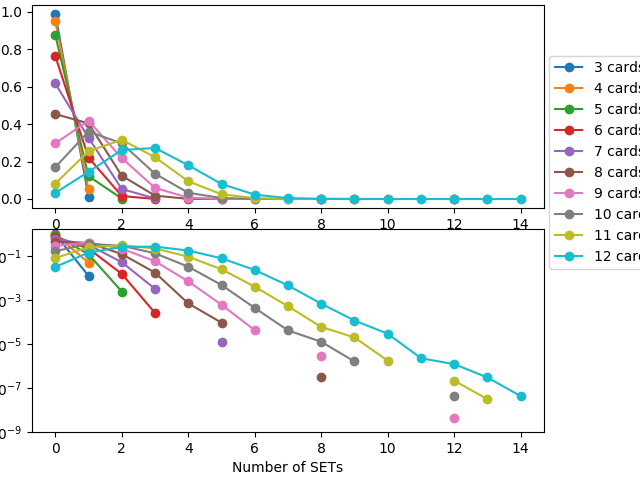

In [12]:
fig,ax = plt.subplots(2,1) # two subplots, 2x1 means above/below, in 1 column

for rowi in rowsk:
    # zero2nan replaces 0 with nan so linespoints will graph appropriately with gaps
    ys = zero2nan(pcts[rowi, colsn], len(colsn))
    # -o means lines and points, colors are automatically chosen
    ax[0].plot    (range(len(ys)), ys, '-o') # ax[0] is top graph;   plot()   does lin scale
    ax[1].semilogy(range(len(ys)), ys, '-o') # ax[1] is bot graph; semilogy() does log scale

# deal with formatting issues
if (len(ntics) == len(colsn)): # if desired x-axis tick marks are specified
    ax[0].set_xticks(ntics)
    ax[1].set_yticks(ntics)
ax[1].set_xlabel('Number of SETs') # label the lower x axis (applies to both)
ax[1].set_ylim([miny,1.8])      # set the y-range of the log graph

# Minimize most of the margins, except leave a wide margin on the right for the legend
plt.subplots_adjust(left=.05, bottom=.1, right=0.85, top=0.99, hspace=0.1)
labelsk = []
for i in rowsk:
    labelsk.append('{} cards'.format(i))
if len(labelsk) <= 20:
    plt.subplots_adjust(left=.05, bottom=.1, right=0.85, top=0.99, hspace=0.1)
    ax[0].legend(labelsk, prop={'size': 10}, loc=(1.01, -0.3))
else:
    plt.subplots_adjust(left=.05, bottom=.1, right=0.99, top=0.99, hspace=0.1)

plt.show()

This block of code creates graphs where the horizontal axis is $k$ cards, and there is a separate curve for each $n$ SETs. The code is identical to the above, except where noted by comments

<IPython.core.display.Javascript object>


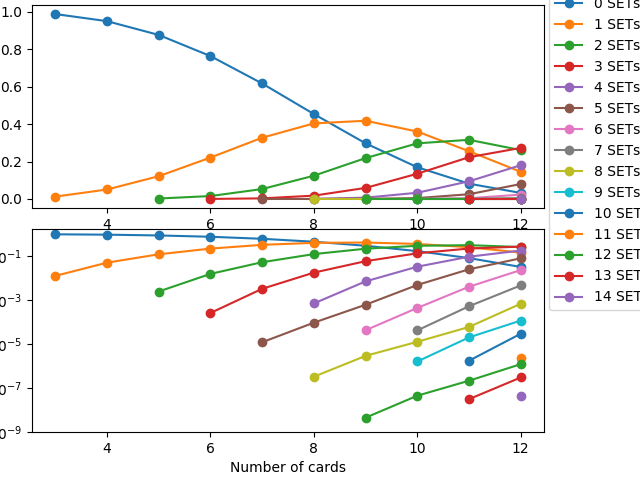

In [13]:
fig,ax = plt.subplots(2,1)

for coli in colsn:                                 # for columns, not rows
    ys = zero2nan(pcts[rowsk, coli], len(rowsk))   # each list of ys is all rows for a particular column
    if verbose:
        print('column', coli)
        print('xs', rowsk)
        print('ys', ys)
    ax[0].plot    (rowsk, ys, '-o') 
    ax[1].semilogy(rowsk, ys, '-o') 

if (len(ktics) == len(rowsk)):                     # mark X axis with ktics
    ax[0].set_xticks(ktics)
    ax[1].set_yticks(ktics)
ax[1].set_xlabel('Number of cards')                # different X axis label
ax[1].set_ylim([miny,1.8])

# nSETs can get so large the legend is out of control. Omit legend if too large
labelsn = []
for i in colsn:
    labelsn.append('{} SETs'.format(i))
if len(labelsn) <= 20:
    ax[0].legend(labelsn, prop={'size': 10}, loc=(1.01, -0.5))
    plt.subplots_adjust(left=.05, bottom=.1, right=0.85, top=0.99, hspace=0.1)
else: # 
    plt.subplots_adjust(left=.05, bottom=.1, right=0.99, top=0.99, hspace=0.1)

plt.show()
